Goal: Use data from [phoible](https://phoible.org/) to learn a useful embedding from phonological feature space to a vector space in which distances between allophones tend to be small. Go to the [phoible project github](https://github.com/phoible/dev/tree/master/data) and grab phoible.csv for this exploration.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn

class EmbedPhones(nn.Module):

    def __init__(self, num_features):
        super(EmbedPhones, self).__init__()
        
        self.res = nn.Linear(num_features,num_features,bias=False)
#         identity=torch.from_numpy(np.identity(num_features,dtype=np.dtype('float32')))
        with torch.no_grad():
            self.res.weight.normal_(0,0.02)
#             self.embed.weight += identity
        
    def forward(self, x):
        
        return x+self.res(x) # res represents the difference between the embedding map and the identity map


In [3]:
import os,sys
def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")

import panphon.featuretable
ft = panphon.featuretable.FeatureTable()

In [4]:
class PanphonNoLikey(Exception):
    pass

class NoAvailableData(Exception):
    pass

def to_panphon_fts(ipa_symbols):
    """ Convert a string of ipa symbols to a numpy matrix whose rows are features.
        Do not include duplicates when panphon identifies symbols in terms of features. """
    if ipa_symbols == "NA" :  raise NoAvailableData("The string you gave indicates that there's no allophone data")
    fts = ft.word_to_vector_list(ipa_symbols,numeric=True)
    if not fts : raise PanphonNoLikey("Panphon does not recognize this IPA symbol")
    fts = np.array(fts) 
    fts = np.unique(fts,axis=0) # panphon will identify some things; this gets rid of duplicates
    fts = fts.astype(np.dtype('float32'))
    return torch.from_numpy(fts)

feats = to_panphon_fts('ɛ æ')
num_features = len(feats[0])
print(num_features," features for 'ɛ æ':\n",feats)
emb = EmbedPhones(num_features)
emb(feats)

22  features for 'ɛ æ':
 tensor([[ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1.,  1., -1., -1., -1.,  1., -1.]])


tensor([[ 0.9875,  0.9508, -1.0109,  0.8489, -1.0821, -0.9516, -0.9688,  0.0137,
          1.0976, -0.9412, -0.9087,  0.1289, -0.9937, -0.1002, -1.0093, -0.9550,
         -1.0120, -0.9801, -1.0466, -0.9510, -0.9890, -1.0063],
        [ 1.0730,  0.9143, -1.0246,  0.8848, -1.0358, -0.9153, -0.9243, -0.0173,
          1.0168, -0.9409, -0.9666,  0.1447, -1.0043, -0.0419, -0.9813, -0.9312,
          1.0069, -1.0088, -1.0312, -1.0657,  1.0583, -0.9335]],
       grad_fn=<AddBackward0>)

In [5]:
import csv

def allophone_data_by_language(num_lists=np.inf):
    f = open('phoible.csv')
    reader = csv.reader(f)
    head = next(reader)
    allophones_index = head.index('Allophones')
    langkey_index = head.index('ISO6393')
    last_langkey = "not a lang key"
    num_yielded = 0
    for i,row in enumerate(reader):
        if row[langkey_index] != last_langkey:
#             print("About to yield data for language",last_langkey)
            last_langkey = row[langkey_index]
            if i!=0 and allophone_data:
                yield allophone_data
                num_yielded += 1
            if num_yielded >= num_lists: break
            allophone_data = []
        try:
            allophone_list = to_panphon_fts(row[allophones_index])
        except PanphonNoLikey: # We will just skip the entire list of allophones in this case
            continue
        except NoAvailableData: # We will just skip the entire list of allophones in this case
            continue
        allophone_data.append(allophone_list)
    f.close()

In [7]:
allophone_data_by_language_list = list(allophone_data_by_language())

In [8]:
import random

def allophone_data_by_language_shuffled():
    indices = list(range(len(allophone_data_by_language_list)))
    random.shuffle(indices)
    for index in indices:
        yield allophone_data_by_language_list[index]

In [9]:
def distinct_pairs(N):
    """Generate pairs of integers i<j such that 0 <= i < j < N"""
    for i in range(N):
        for j in range(i+1,N):
            yield i,j

In [10]:
def sqdist(x,y):
    """Return squared distance between two 1D torch tensors"""
    return ((x-y)**2).sum()

In [24]:
import torch.optim as optim

emb = EmbedPhones(num_features)
lr = 0.0001
optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=1.)

In [25]:
epochs = 4
costs = []
for e in range(epochs):
    for step_num,allophone_data in enumerate(allophone_data_by_language_shuffled()):

        allophone_dists   = 0.
        nallophone_dists  = 0. 

        optimizer.zero_grad()

        for allophone_list in allophone_data:
            for i,j in distinct_pairs(len(allophone_list)):
                allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
        for i,j in distinct_pairs(len(allophone_data)):
            for x in allophone_data[i]:
                for y in allophone_data[j]:
                    nallophone_dists += sqdist(emb(x),emb(y))

        cost = allophone_dists - 0.05 * nallophone_dists
        cost.backward()
        costs.append(cost.item())
        if step_num%50==0:
            print(step_num,"languages processed. Avg cost: ",np.mean(costs))
            costs = []
        optimizer.step()

0 languages processed. Avg cost:  -1460.8521728515625
50 languages processed. Avg cost:  -1503.3360885620118
100 languages processed. Avg cost:  -4249.62675415039
150 languages processed. Avg cost:  -1321.8668353271485
200 languages processed. Avg cost:  -2573.298227844238
250 languages processed. Avg cost:  -1988.411904296875
300 languages processed. Avg cost:  -1502.9762258911132
350 languages processed. Avg cost:  -1612.1276971435548
400 languages processed. Avg cost:  -1405.1731420898439
450 languages processed. Avg cost:  -3501.915505371094
500 languages processed. Avg cost:  -1530.2258169555664
550 languages processed. Avg cost:  -1712.7431854248048
600 languages processed. Avg cost:  -4124.578305358887
650 languages processed. Avg cost:  -1924.862767944336
700 languages processed. Avg cost:  -1695.6082055664062
750 languages processed. Avg cost:  -1790.1763726806641
800 languages processed. Avg cost:  -1780.4346197509765
850 languages processed. Avg cost:  -2070.85224609375
900 

In [26]:
emb.res.weight

Parameter containing:
tensor([[ 0.1669,  0.1821, -0.1601,  0.1752, -0.1902, -0.1863, -0.0120, -0.1262,
          0.1470, -0.0910, -0.1465, -0.1889, -0.1740,  0.1545, -0.1539,  0.1495,
          0.1370,  0.1729,  0.1317, -0.0358,  0.1513,  0.0916],
        [ 0.1703,  0.1615, -0.1601,  0.1878,  0.1084,  0.1633,  0.1251, -0.1307,
          0.1653, -0.1039, -0.0970, -0.2063, -0.1747,  0.1588, -0.0884,  0.1362,
          0.2000,  0.1603,  0.1456, -0.0093,  0.1840,  0.1085],
        [-0.1747, -0.1669,  0.2123, -0.2316,  0.1628,  0.1897,  0.0788,  0.1241,
         -0.1663,  0.1408, -0.0038,  0.1890,  0.1481, -0.1995,  0.1694, -0.1399,
         -0.1581, -0.1991, -0.1249,  0.0045, -0.1479, -0.0870],
        [ 0.1887,  0.1884, -0.2024,  0.2029,  0.1784,  0.1638, -0.1129,  0.1031,
          0.1870, -0.1131, -0.1538, -0.1494, -0.1639,  0.1244, -0.1823,  0.0396,
          0.1433,  0.1756,  0.1674, -0.0285,  0.1923,  0.1566],
        [-0.2229, -0.2311,  0.2387, -0.1261,  0.1667,  0.1597, -0.1124,  0

In [27]:
def dist(x,y):
    """distance between two feature vectors (1d torch tensors) after embedding"""
    return torch.sqrt(sqdist(emb(x),emb(y))).item()

Loading Epitran with language code ind-Latn... success!
22.931230545043945 1.3032283782958984


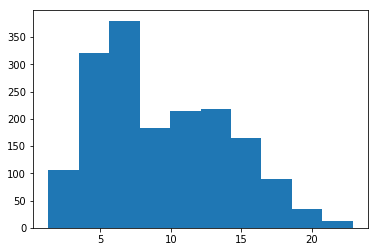

In [28]:
from wordgen import *
wg = WordgenLearned(3,"ind-Latn")

ipa_chars = wg.load_ipa_chars('eng-Latn')

dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = to_panphon_fts(c1),to_panphon_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)
print(max_dist,min_dist)
plt.hist(dists)
plt.show()

In [37]:
ipa_chars = list(wg.load_ipa_chars('ind-Latn')) # now this is an ordered list, kind of serving as an enumeration
num_chars = len(ipa_chars)
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 25
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    ipa_char_index = np.random.randint(num_chars)
    s0 = to_panphon_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = to_panphon_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break

In [38]:
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['ɲ']
['r']
['b']
['ʔ']
['w']
['ə']
['ŋ']
['i']
['u']
['h']
['f']
['m']
['j']
['ɡ', 'x']
['k']
['d']
['l']
['t͡ɕ', 'd͡ʑ', 'ɕ']
['o']
['a']
['s', 'z']
['t']
['n']
['p']


Next: It makes sense that the embedding is cramming together any potential allophones to be really close together, becuase it makes sense to do that and to make up for it by just pushing things more far apart in general. Hmm what do...

Basically the issue was that attraction was stronger than repulsion. Strengthening repulsion a bit helped to remedy the problem. The histogram of distances has a spike at small distances, which we could visibly see moving to the right.

Next: Run a search, bascially, over different values of that hyperparameter that governs attractions vs repulsion. For each value, show the histogram of distances. Choose the histogram that looks the most "balanced" and try that.